In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from scipy.signal import savgol_filter
import pywt
import scaleogram as scg

## Read in the clustered data

In [6]:
data = pd.read_pickle("../rates_and_clusters/ratesClusters_filled_days.pkl")

data = data[['AllDates', 'cluster', 'Taken Date', 'INCONCLUSIVE', 'NEGATIVE', 'POSITIVE', 'Total']]
data['posRate'] = data['POSITIVE'] / data['Total'] # this will give NaN when total = 0
data.fillna(0, inplace=True)
data.head()

,AllDates,cluster,Taken Date,INCONCLUSIVE,NEGATIVE,POSITIVE,Total,posRate
0,2020-01-21,0,0,0.0,0.0,0.0,0.0,0.0
1,2020-01-22,0,0,0.0,0.0,0.0,0.0,0.0
2,2020-01-23,0,0,0.0,0.0,0.0,0.0,0.0
3,2020-01-24,0,0,0.0,0.0,0.0,0.0,0.0
4,2020-01-25,0,0,0.0,0.0,0.0,0.0,0.0


## Plotting and smoothing

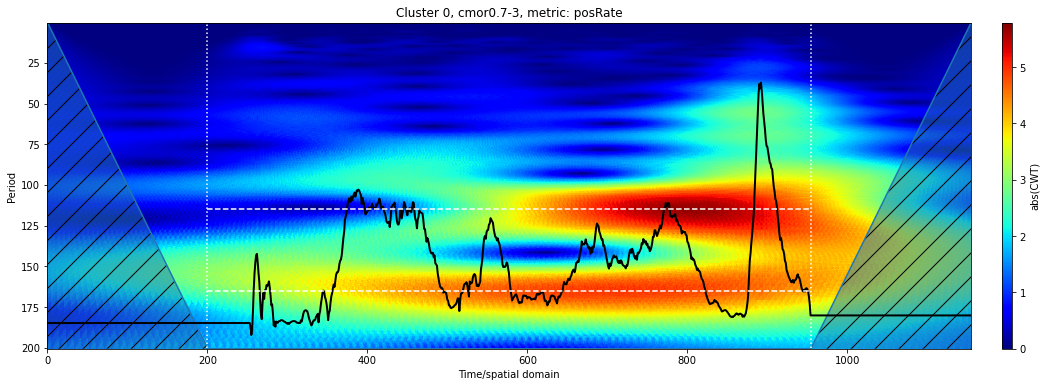

In [130]:
def smooth(x, window=13, polyorder=3, deriv=0):
    '''
    smooth is used in the graphScales function.  
    To disable: window=1, polyorder = 0
    '''
    x = savgol_filter(x, window_length=window,polyorder=polyorder, deriv=deriv, mode='interp')
    return x

def graphScales(data, metric, s, wavelet, coi, padLen, padMode, cluster, spectrum, yaxis):
    '''
    
    https://pywavelets.readthedocs.io/en/latest/ref/index.html
    
    https://github.com/alsauve/scaleogram
    
    data: a dataframe
    metric: the column in the dataframe you want to use
    s: the scales used, input as an array
    wavelet: refer to pyWavelets documantation
    coi: Cone of inference, True of False
    padLen:  How many data point to pad with, front and back
    padMode: which mode to use for pading, refer to pyWavelets documentation
    cluster: the cluster of interest    
    '''
    
    data = data[data['cluster']==cluster]
    
    # we can get x data from y len
    y = data[f'{metric}'].array.reshape(-1,1)
    
    # Standardize features by removing the mean and scaling to unit variance.
    # https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html
    y = StandardScaler().fit_transform(y)
    y = y.reshape(1,-1)[0]
    
    #smooth
    y = smooth(y)
    
    #pad the data
    yPadded = pywt.pad(y, padLen, padMode)
    
    # make an array of scales
    scales = np.arange(s[0], s[1])
    
    # Plot the data
    #fig, (ax1, ax2) = plt.subplots(2,1, figsize=(18,8))
    fig,  ax2 = plt.subplots(1,1, figsize=(18,6))
    #fig.subplots_adjust(hspace=0.3)    
    
    # Plot the signal
    #ax1.plot(np.arange(0, len(yPadded)), yPadded)   
    # add pading lines as indication of what is important
    #ax1.vlines(x=[padLen, len(yPadded) - padLen, 850], 
    #           ymin=min(yPadded), ymax=max(yPadded), color='black', ls="dotted")
    
    
    # Plot the scaleogram
    ax2 = scg.cws(np.arange(0, len(yPadded)), yPadded, scales=scales, wavelet=wavelet, 
                  coi=coi, ax=ax2, 
                  title = f'Cluster {cluster}, {wavelet}, metric: {metric}',
                 cbar='vertical', yaxis=yaxis, spectrum=spectrum, cmap='jet')
     
    ax2.vlines(x= [padLen, (len(yPadded) - padLen)], 
               ymin=200, ymax=0, color='white', ls="dotted")
    ax2.plot(np.arange(0, len(yPadded)), 150-yPadded*30, color='black', lw=2)
    ax2.hlines(y=[165, 115], xmin=padLen, xmax=(len(yPadded) - padLen), color='white', ls='dashed')
    
    

graphScales(data=data,metric='posRate', s=[1,600], wavelet='cmor0.7-3', coi=True, padLen=200, padMode='constant', cluster='0',
           spectrum='amp', yaxis='period')

### Other smoothing options

* ifft
* kalman, https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html
* or smoothing is not needed since the wavelet act as a band pass filter


In [96]:
scales = np.arange(1,200,1)
freqList = []
for s in scales:
    f = pywt.scale2frequency('cmor0.5-3', s)
    freqList.append(f)

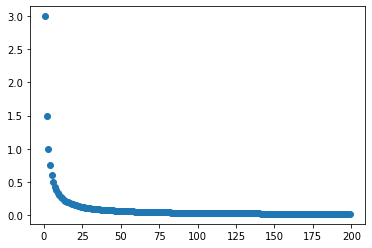

In [97]:
plt.scatter(scales, freqList);